<center>机器学习-第二次作业<br>
第二组工程文件</center>

In [1]:
#请输入CSV文件目录以更改数据集
csv_path = 'Data\Default_train.csv'

In [2]:
#这个cell提供了可供更改的参数，修改参数可能影响模型训练的参数和性能
MAX_ITERATION_LOOPS = 10000 #拟合模型的最大循环次数
DESCENT_DROP_VALUE = 0.1 #认为梯度不再下降，停止拟合的最小值
THRESH_VALUE = 0.7 #激活函数判断的阈值

In [3]:
#运行本notebook需要以下库，如本cell报错，请先安装库
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

<center>模型与定义部分</center>

In [4]:
def load_complete_data(path): #读入完整数据并预先完成预处理
    sourcedata = pd.read_csv(path,header=0,index_col=0) #读入csv文件
    sourcedata = sourcedata.replace('Yes',1) #对于yes,no量，将其转化成0与1
    sourcedata = sourcedata.replace('No',0)
    raw_x = np.array(sourcedata[['student','balance','income']])
    input_y = np.array(sourcedata[['default']]) #形成输入数组
    input_x = np.zeros(shape=(raw_x.shape[0],5)) #input_x的结构：balance,income,isstudent,notstudent,b(固定为1)
    for i in range (0,raw_x.shape[0]): 
        if raw_x[i][0]==1: input_x[i][2] = 1 #录入isstudent,notstudent,以及更改b为1
        else: input_x[i][3] = 1
        input_x[i][4] = 1
    input_x[:,0:2] = raw_x[:,1:3]
    input_x[:,0]/=1000 #将income列除以1e4，balance列除以1e3
    input_x[:,1]/=10000 #这两行的目的是均一化处理，使得数组归到一个数量级
    return input_x,input_y

def tenfold_devider(full_x,full_y): #将完整数据集进行十折运算切割
    xy=np.hstack((full_x,full_y)) #连接在一起便于KFold
    kf = KFold(n_splits=10, shuffle=True,random_state=1)
    x_tr = []
    y_tr = []
    x_te = []
    y_te = []
    for train_index, test_index in kf.split(xy): #按照十折结果分配数据
        xy_tr, xy_te = xy[train_index], xy[test_index]
        x_tr.append(xy_tr[:, 0:5])
        y_tr.append(xy_tr[:, 5])
        x_te.append(xy_te[:, 0:5])
        y_te.append(xy_te[:, 5])
    return x_tr,y_tr,x_te,y_te

In [5]:
def Positive_Probability(tocal_x,param_omega): #西瓜书 正例计算公式，即p
    return (np.exp(np.matmul(tocal_x,param_omega))/(1+np.exp(np.matmul(tocal_x,param_omega))))

def REML_Calculation(tocal_x,tocal_y,param_omega): #对数似然计算函数，输入x向量与y向量，以及输入omega列向量，即f
    return np.sum((-tocal_y*(np.matmul(tocal_x,param_omega)))+np.log(1+np.exp(np.matmul(tocal_x,param_omega))))

def GRA_Calculation(tocal_x,tocal_y,param_omega): #梯度计算，输入x向量与y向量，以及输入omega列向量，即f_
    GRA_sum = tocal_x*(tocal_y-Positive_Probability(tocal_x,param_omega))
    GRA_sum = np.sum(GRA_sum,axis=0)
    return (-(GRA_sum.T))

In [6]:
class LogisticRegressionModel():
    def __init__(self,inputx,inputy):
        self.omegaprocess=np.zeros(shape=(5,1,MAX_ITERATION_LOOPS+2)) #历次迭代中计算的omega
        self.omegaprocess[:,:,0]=[[0.01],[0.01],[0.01],[0.01],[0.01]] #初始omega
        self.REML_descent=[] #均方误差下降的大小
        self.REML_list=[] #每次迭代的均方误差
        self.totaliterations = 0 #总共迭代的次数
        self.input_x = inputx
        self.input_y = inputy
    
    def train(self):
        iterations = 0
        while (iterations<MAX_ITERATION_LOOPS): #防止迭代次数过多，制定返回上限
            iterations+=1
            REML_in_loop = REML_Calculation(self.input_x,self.input_y,self.omegaprocess[:,:,iterations-1]) #计算本次迭代的梯度和对数似然
            GRA_in_loop = GRA_Calculation(self.input_x,self.input_y,self.omegaprocess[:,:,iterations-1])
            REML_tostat_MIN = 1e11
            Effi_index = 0

            for i in range(1,101): #一维搜索确定步长
                omegapredict = self.omegaprocess[:,:,iterations-1] - (0.001/i) * np.resize(GRA_in_loop,(5,1))
                REMLtemp = REML_Calculation(self.input_x,self.input_y,omegapredict)
                if (REMLtemp<REML_tostat_MIN):
                    Effi_index=i
                    REML_tostat_MIN = REMLtemp
                    
            self.omegaprocess[:,:,iterations] = self.omegaprocess[:,:,iterations-1] - (0.001/Effi_index) * np.resize(GRA_in_loop,(5,1)) #参数omega进行迭代
            self.REML_descent.append(abs(REML_Calculation(self.input_x,self.input_y,self.omegaprocess[:,:,iterations])-REML_in_loop)) #记录对数似然下降量
            self.REML_list.append(REML_in_loop)
            if (self.REML_descent[-1]<DESCENT_DROP_VALUE): break #认为其不再收敛
        self.totaliterations = iterations

    def show_training_info(self): #打印收敛步数与拟合参数
        print("收敛步数：%d"%self.totaliterations)
        print("拟合参数：",end='')
        print(self.omegaprocess[:,:,self.totaliterations].reshape(1,-1)[0])

    def self_result_analyzation(self): #计算结果，使用自身数据
        result_y_raw = np.exp(np.matmul(self.input_x,self.omegaprocess[:,:,self.totaliterations]))/(1+np.exp(np.matmul(self.input_x,self.omegaprocess[:,:,self.totaliterations])))
        result_activated = (result_y_raw)/(1-result_y_raw)
        result_y = np.zeros(shape=(np.shape(self.input_x)[0],1))
        for i in range(0,np.shape(self.input_x)[0]):
            if (result_activated[i][0]>THRESH_VALUE): result_y[i][0]=1

        #统计样本
        True_Positive = 0
        True_Negative = 0
        False_Positive = 0
        False_Negative = 0
        for i in range(0,np.shape(result_y)[0]):
            if (result_y[i][0]==self.input_y[i][0] and result_y[i][0]==1): True_Positive+=1
            elif (result_y[i][0]==0 and self.input_y[i][0]==1): False_Negative+=1
            elif (result_y[i][0]==1 and self.input_y[i][0]==0): False_Positive+=1
            else :True_Negative+=1

        Recall_Ratio = True_Positive/(True_Positive+False_Negative) #查全率
        Precision_Ratio = True_Positive/(True_Positive+False_Positive) #查准率
        Accurancy_Rate = (True_Positive+True_Negative)/np.shape(result_y)[0] #准确率
        print("【对训练集自身的重新估计结果】")
        print("查全率:%f"%Recall_Ratio)
        print("查准率:%f"%Precision_Ratio)
        print("准确率:%f"%Accurancy_Rate)
    
    def inp_result_analyzation(self,test_x,test_y): #使用输入测试集计算结果
        result_y_raw = np.exp(np.matmul(test_x,self.omegaprocess[:,:,self.totaliterations]))/(1+np.exp(np.matmul(test_x,self.omegaprocess[:,:,self.totaliterations])))
        result_activated = (result_y_raw)/(1-result_y_raw)
        result_y = np.zeros(shape=(np.shape(test_x)[0],1))
        for i in range(0,np.shape(test_x)[0]):
            if (result_activated[i][0]>THRESH_VALUE): result_y[i][0]=1

        #统计样本
        True_Positive = 0
        True_Negative = 0
        False_Positive = 0
        False_Negative = 0
        for i in range(0,np.shape(result_y)[0]):
            if (result_y[i][0]==test_y[i][0] and result_y[i][0]==1): True_Positive+=1
            elif (result_y[i][0]==0 and test_y[i][0]==1): False_Negative+=1
            elif (result_y[i][0]==1 and test_y[i][0]==0): False_Positive+=1
            else :True_Negative+=1

        Recall_Ratio = True_Positive/(True_Positive+False_Negative) #查全率
        Precision_Ratio = True_Positive/(True_Positive+False_Positive) #查准率
        Accurancy_Rate = (True_Positive+True_Negative)/np.shape(result_y)[0] #准确率
        print("【对测试数据集的拟合结果】")
        print("查全率:%f"%Recall_Ratio)
        print("查准率:%f"%Precision_Ratio)
        print("准确率:%f"%Accurancy_Rate)
        return Recall_Ratio,Precision_Ratio,Accurancy_Rate

    def plot_training_parameters(self): #画出对数似然变化图象
        plt.figure(figsize=(15,6),dpi=80)
        plt.subplot(1,2,1)
        plt.plot(self.REML_descent)
        plt.xscale('log')
        plt.yscale('log')
        plt.title("REML Descent Value in every iteration")
        plt.subplot(1,2,2)
        plt.plot(self.REML_list)
        plt.xscale('log')
        plt.title("REML Value in every iteration")
        print("【收敛参数图像】")
        plt.show()

<center>数据验证，模型训练与十折运算验证部分</center>


----------【十折训练组：1】----------
收敛步数：281
拟合参数：[ 4.77841302 -0.16007679 -3.41370773 -2.59961894 -6.02332667]
【收敛参数图像】


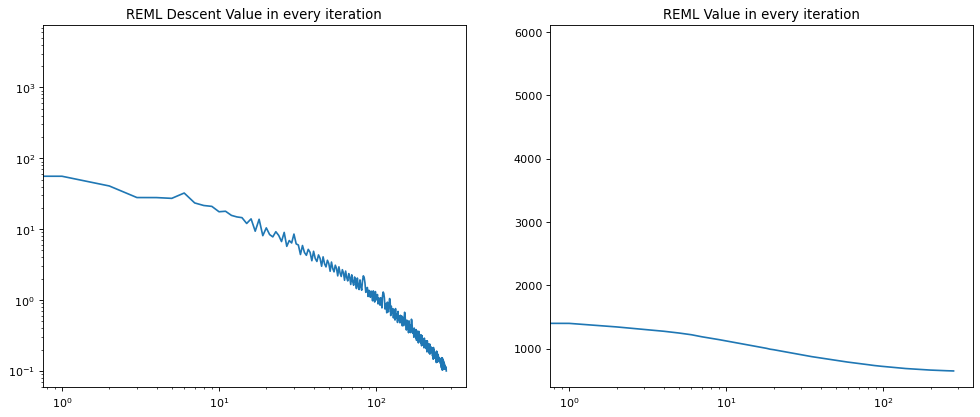

【对训练集自身的重新估计结果】
查全率:0.391941
查准率:0.636905
准确率:0.971975
【对测试数据集的拟合结果】
查全率:0.352941
查准率:0.631579
准确率:0.967778

----------【十折训练组：2】----------
收敛步数：266
拟合参数：[ 4.72372183 -0.21615963 -3.37454334 -2.49448136 -5.8790247 ]
【收敛参数图像】


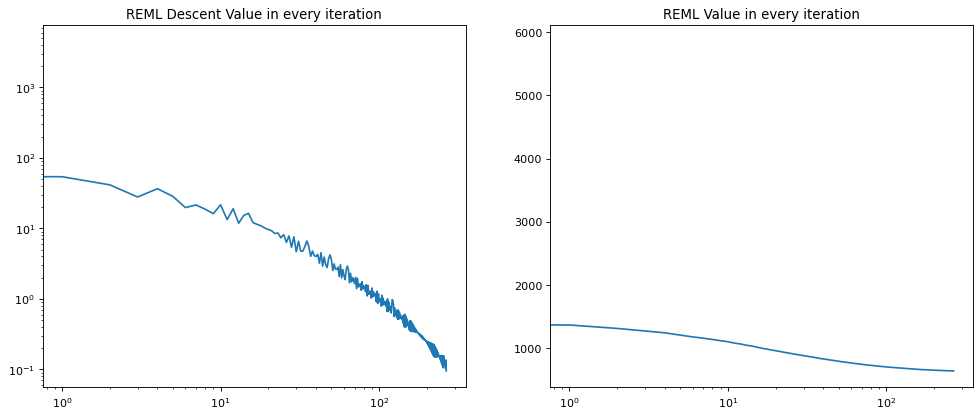

【对训练集自身的重新估计结果】
查全率:0.363296
查准率:0.638158
准确率:0.972222
【对测试数据集的拟合结果】
查全率:0.400000
查准率:0.640000
准确率:0.963333

----------【十折训练组：3】----------
收敛步数：266
拟合参数：[ 4.71699912 -0.16119439 -3.40398396 -2.56762124 -5.9816052 ]
【收敛参数图像】


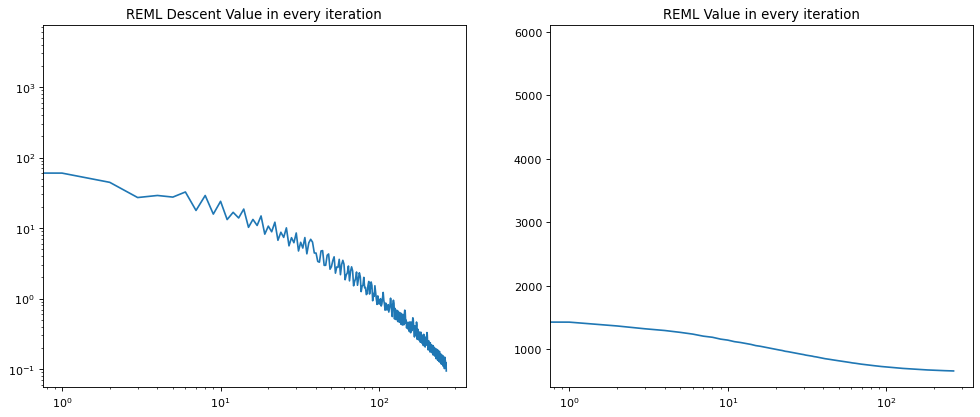

【对训练集自身的重新估计结果】
查全率:0.383513
查准率:0.664596
准确率:0.972099
【对测试数据集的拟合结果】
查全率:0.357143
查准率:0.625000
准确率:0.973333

----------【十折训练组：4】----------
收敛步数：269
拟合参数：[ 4.76783046 -0.20405849 -3.42504431 -2.48598989 -5.9210342 ]
【收敛参数图像】


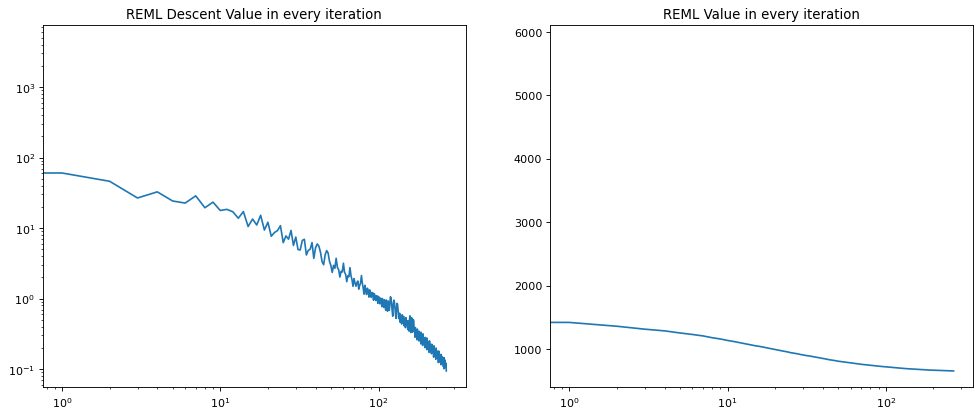

【对训练集自身的重新估计结果】
查全率:0.401434
查准率:0.625698
准确率:0.971111
【对测试数据集的拟合结果】
查全率:0.321429
查准率:0.692308
准确率:0.974444

----------【十折训练组：5】----------
收敛步数：253
拟合参数：[ 4.66738877 -0.19039356 -3.41567921 -2.42948773 -5.85516693]
【收敛参数图像】


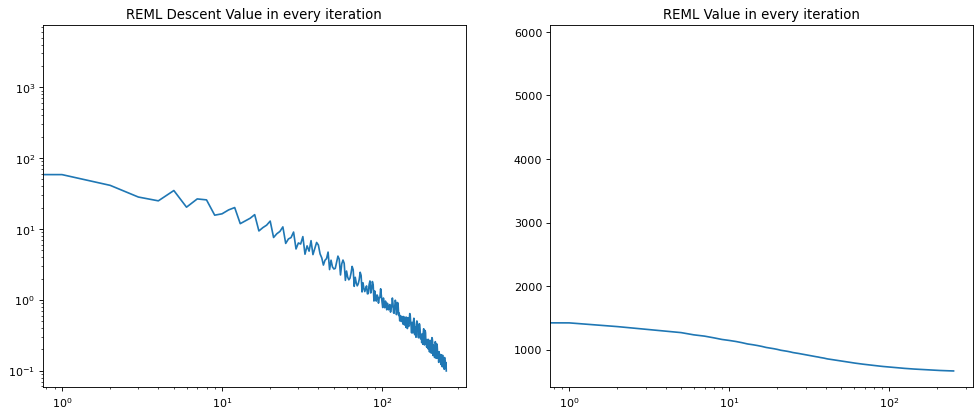

【对训练集自身的重新估计结果】
查全率:0.384058
查准率:0.662500
准确率:0.972346
【对测试数据集的拟合结果】
查全率:0.419355
查准率:0.565217
准确率:0.968889

----------【十折训练组：6】----------
收敛步数：267
拟合参数：[ 4.72249225 -0.16634165 -3.41652248 -2.53968369 -5.96620617]
【收敛参数图像】


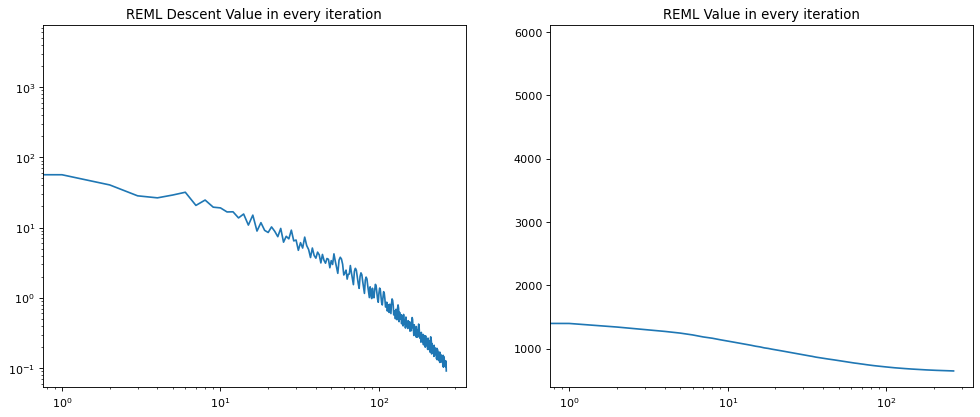

【对训练集自身的重新估计结果】
查全率:0.380952
查准率:0.645963
准确率:0.972099
【对测试数据集的拟合结果】
查全率:0.382353
查准率:0.650000
准确率:0.968889

----------【十折训练组：7】----------
收敛步数：271
拟合参数：[ 4.763413   -0.18584619 -3.40031797 -2.53045488 -5.94077285]
【收敛参数图像】


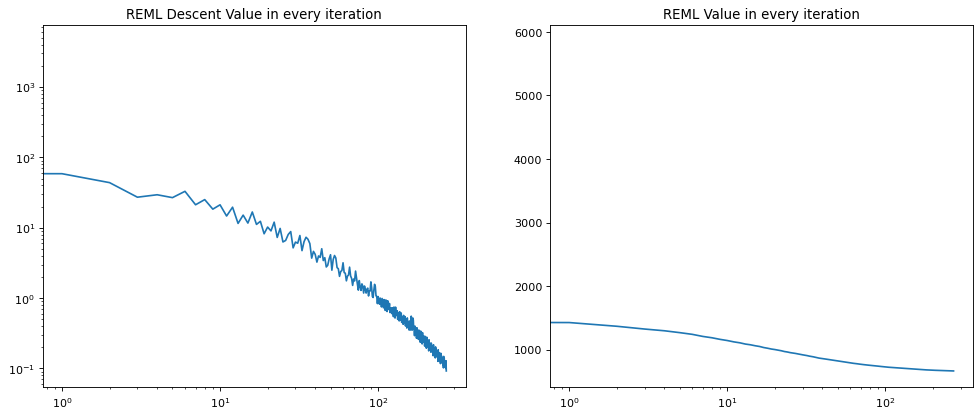

【对训练集自身的重新估计结果】
查全率:0.397163
查准率:0.629213
准确率:0.970864
【对测试数据集的拟合结果】
查全率:0.480000
查准率:0.705882
准确率:0.980000

----------【十折训练组：8】----------
收敛步数：268
拟合参数：[ 4.77873862 -0.18725847 -3.4713591  -2.50876488 -5.99012398]
【收敛参数图像】


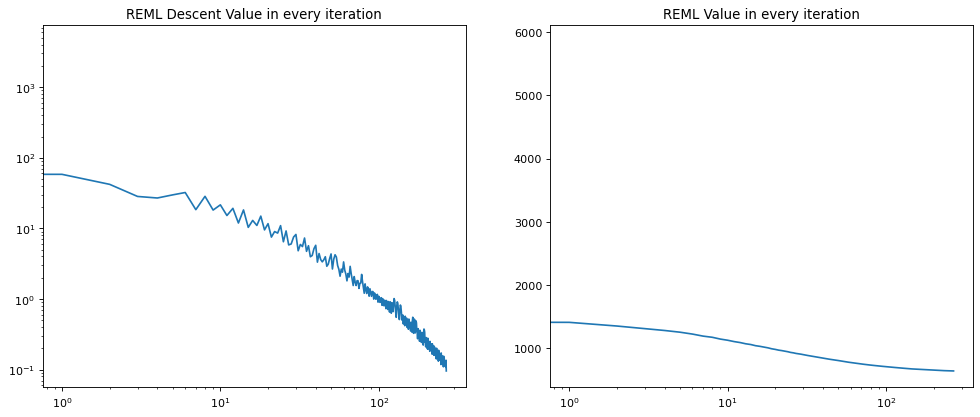

【对训练集自身的重新估计结果】
查全率:0.385455
查准率:0.654321
准确率:0.972222
【对测试数据集的拟合结果】
查全率:0.406250
查准率:0.590909
准确率:0.968889

----------【十折训练组：9】----------
收敛步数：267
拟合参数：[ 4.71208916 -0.16115669 -3.38815921 -2.55878942 -5.95694862]
【收敛参数图像】


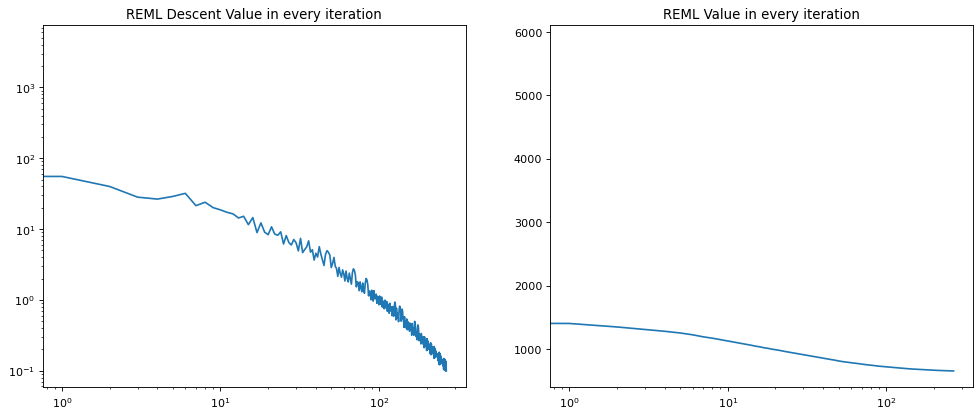

【对训练集自身的重新估计结果】
查全率:0.385455
查准率:0.627219
准确率:0.971358
【对测试数据集的拟合结果】
查全率:0.343750
查准率:0.846154
准确率:0.974444

----------【十折训练组：10】----------
收敛步数：278
拟合参数：[ 4.81748389 -0.20272363 -3.39995495 -2.56948481 -5.97943976]
【收敛参数图像】


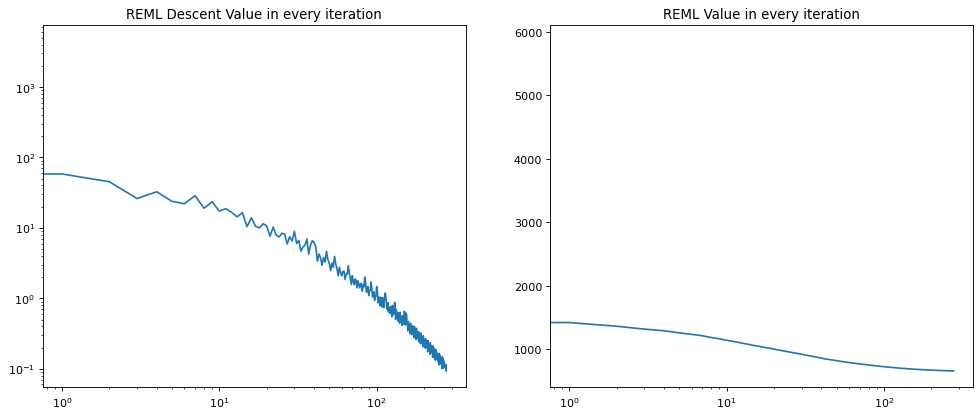

【对训练集自身的重新估计结果】
查全率:0.401408
查准率:0.655172
准确率:0.971605
【对测试数据集的拟合结果】
查全率:0.347826
查准率:0.470588
准确率:0.973333

----------【十折训练集总结】-----------
十折的平均查全率：0.381105
十折的平均查准率：0.641764
十折的平均准确率：0.971333

----------【训练组：全数据模型】-----------
【对训练集自身的重新估计结果】
查全率:0.381107
查准率:0.635870
准确率:0.971444
【收敛参数图像】


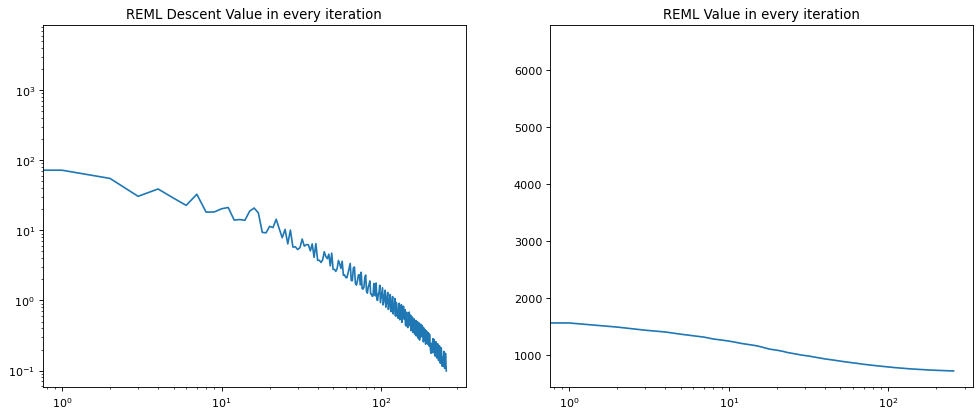

In [7]:
input_x,input_y = load_complete_data(csv_path)
tf_xtrain, tf_ytrain, tf_xtest, tf_ytest = tenfold_devider(input_x,input_y)

RRlist = []
PRlist = []
ARlist = []

for i in range(1,11): #对十折后的数据集分别建立模型并分析，将数据存储
    themodel = LogisticRegressionModel(tf_xtrain[i-1],np.array(tf_ytrain[i-1]).reshape(-1,1))
    themodel.train()
    print("\n----------【十折训练组：%d】----------"%i)
    themodel.show_training_info()
    themodel.plot_training_parameters()
    themodel.self_result_analyzation()
    RR,PR,AR = themodel.inp_result_analyzation(tf_xtest[i-1],tf_ytest[i-1].reshape(-1,1))
    RRlist.append(RR)
    PRlist.append(PR)
    ARlist.append(AR)
print("\n----------【十折训练集总结】-----------")
print("十折的平均查全率：%f"%np.mean(RRlist))
print("十折的平均查准率：%f"%np.mean(PRlist))
print("十折的平均准确率：%f"%np.mean(ARlist))
print("\n----------【训练组：全数据模型】-----------") #分析全模型
full_model = LogisticRegressionModel(input_x,input_y)
full_model.train()
full_model.self_result_analyzation()
full_model.plot_training_parameters()